In [4]:
import torch
import torchaudio
import matplotlib.pyplot as plt

filename = "/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR1/FAKS0/SA1.WAV"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

#plt.figure()
#plt.plot(waveform.t().numpy())

Shape of waveform: torch.Size([1, 63488])
Sample rate of waveform: 16000
tensor([[9.1553e-05, 1.5259e-04, 6.1035e-05,  ..., 2.4414e-04, 3.0518e-04,
         2.1362e-04]])


In [3]:
######################### MEME TAILLE DE SIGNAUX
from fonctions import *

taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR1")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR2")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR3")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR4")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR5")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR6")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR7")
taille_sig("/home/ptit/Documents/dnn-audio/Data/speech_TEST/TIMIT_TEST/DR8")

'import os\nfrom fonctions import *\n\nRSB = input(\'entrer le RSB voulu\')\nbruit, sample_rate_bruit = torchaudio.load("/Users/Ptit Miracle/Documents/projet_audio/babble.WAV")\nbruit_rs = torchaudio.transforms.Resample(sample_rate_bruit, 16000)(bruit)\nfor subdir, dirs, files in os.walk("\\Users\\Ptit Miracle\\Documents\\projet_audio\\meme_taille_TEST"):\n    for file in files:\n        if (\'.WAV\' in file):\n            subpath = os.path.join(subdir, file)\n            save_bruit(subpath, bruit, bruit_rs, RSB)\n        '

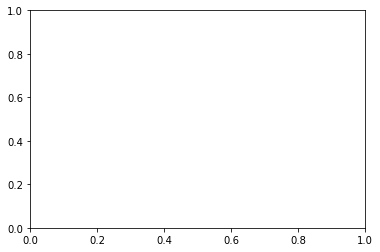

In [12]:
####################### SIGNAUX NON BRUITÉS
for subdir, dirs, files in os.walk("/home/ptit/Documents/dnn-audio/Data/meme_taille_TEST"):
    for file in files:
            subpath = os.path.join(subdir, file)
            waveform, sample_rate = torchaudio.load(subpath)
            spec, f, t, im = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = True, mode = 'psd', cmap = 'gray')
            #on ajoute le spectro au dossier
            path_list = subpath.split("/")
            path_list[6] = 'non_bruité' + "_" + path_list[6][11:]
            br_name = path_list[7][:-3] + 'png'

            plt.axis('off')
            plt.savefig('/home/ptit/Documents/dnn-audio/Data/' + path_list[6] + '/' + br_name,bbox_inches='tight')
            plt.clf()
            plt.cla()
            
######################## BRUITAGE DES SIGNAUX
"""import os
from fonctions import *

RSB = input('entrer le RSB voulu')
bruit, sample_rate_bruit = torchaudio.load("/Users/Ptit Miracle/Documents/projet_audio/babble.WAV")
bruit_rs = torchaudio.transforms.Resample(sample_rate_bruit, 16000)(bruit)
for subdir, dirs, files in os.walk("\\Users\\Ptit Miracle\\Documents\\projet_audio\\meme_taille_TEST"):
    for file in files:
        if ('.WAV' in file):
            subpath = os.path.join(subdir, file)
            save_bruit(subpath, bruit, bruit_rs, RSB)
        """    

In [71]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 20
epochs = 20
learning_rate = 1e-3

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

spec = mpimg.imread('/home/ptit/Documents/dnn-audio/Data/bruité__TEST_RSB=0.7/sig_1_0.png')

In [14]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os

test_loader = torchvision.datasets.ImageFolder('/home/ptit/Documents/dnn-audio/Data/bruité__TEST_RSB=0.7')
init_loader = torchvision.datasets.ImageFolder('/home/ptit/Documents/dnn-audio/Data/non_bruité__TEST')

class loader(torch.utils.data.Dataset):
    def __init__(self, im_br, im):
        self.im_br = im_br
        self.im = im


RuntimeError: Found 0 files in subfolders of: /home/ptit/Documents/dnn-audio/Data/non_bruité__TEST
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [3]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=3, kernel_size=3
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=3, out_channels=2, kernel_size=3
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.decoder_hidden_layer = nn.ConvTranspose2d(
            in_channels=2, out_channels=3, kernel_size=2, stride=2
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=3, out_channels=1, kernel_size=2,stride=2
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer2(features)
        activation = torch.relu(activation)
        code = self.pool(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        reconstructed = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [5]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

/home/ptit/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 349*231] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 349*231).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model"+str(epoch))
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

NameError: name 'train_loader' is not defined